# HM2: Numerical Optimization for Logistic Regression.

### Name: [Your-Name?]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.06887773  0.073507    0.06759183  0.03109921 -0.11969166 -0.02579084
   0.07636791  0.06769486]]
test std = 
[[0.97521551 1.09228523 0.81434122 0.94778841 0.88413219 0.95075151
  1.12409871 1.0468256 ]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [ ]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [6]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [7]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [8]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5973740751234956
Objective value at t=2 is 0.558346522118186
Objective value at t=3 is 0.5372755549956805
Objective value at t=4 is 0.5240923738287032
Objective value at t=5 is 0.5151623806934683
Objective value at t=6 is 0.5088154391743728
Objective value at t=7 is 0.5041566468563976
Objective value at t=8 is 0.5006560256661937
Objective value at t=9 is 0.4979778171370282
Objective value at t=10 is 0.4958989583035701
Objective value at t=11 is 0.49426594851741623
Objective value at t=12 is 0.49297022663139306
Objective value at t=13 is 0.4919332941655367
Objective value at t=14 is 0.49109732980025933
Objective value at t=15 is 0.4904190639189706
Objective value at t=16 is 0.4898656692212737
Objective value at t=17 is 0.48941193952472883
Objective value at t=18 is 0.4890383141192061
Objective value at t=19 is 0.4887294699323283
Objective value at t=20 is 0.48847330262067623
Objective value at t=21 is 0.48826017877

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [9]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam): 
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [10]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [11]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5502829638407191
Objective value at epoch t=1 is 0.536120603031266
Objective value at epoch t=2 is 0.5277936898982327
Objective value at epoch t=3 is 0.5208127982490292
Objective value at epoch t=4 is 0.5242948745525599
Objective value at epoch t=5 is 0.5185612361524566
Objective value at epoch t=6 is 0.5166799219069451
Objective value at epoch t=7 is 0.5143155561758533
Objective value at epoch t=8 is 0.5089751785106642
Objective value at epoch t=9 is 0.5074940348001975
Objective value at epoch t=10 is 0.5079154766964419
Objective value at epoch t=11 is 0.5020780028797438
Objective value at epoch t=12 is 0.5046902754795582
Objective value at epoch t=13 is 0.5008606015780679
Objective value at epoch t=14 is 0.5025997701709877
Objective value at epoch t=15 is 0.5005184625602878
Objective value at epoch t=16 is 0.5001648264870167
Objective value at epoch t=17 is 0.496951690520974
Objective value at epoch t=18 is 0.4980505394105458
Objective value at epoch

# 4. Compare GD with SGD

Plot objective function values against epochs.

<ipython-input-12-9b8d8f4cdfb5>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
<ipython-input-12-9b8d8f4cdfb5>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
<ipython-input-12-9b8d8f4cdfb5>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel('Epochs', FontSize=20)
<ipython-input-12-9b8d8f4cdfb5>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Objective Value', FontSize=20)
<ipython-input-12-9b8d8f4cdfb5>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 

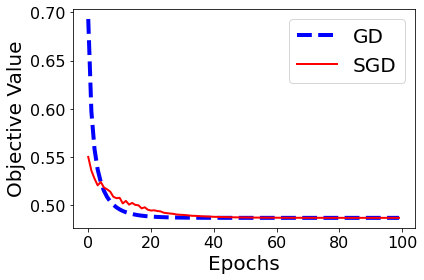

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [13]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [14]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2265625


In [15]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.1796875


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [30]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
import math
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    n,d = xi.shape
    yx = numpy.multiply(yi, xi) # b-by-d matrix
    yxw = numpy.dot(yx, w) #b-by-1 matrix
    
    # calculate objective function Q_i
    loss = numpy.mean(numpy.log(1 + numpy.exp(-yxw)))  #b-by-1 matrix
    reg = lam/2 * numpy.sum(w * w) #scalar
    obj = loss + reg
    
    
    # calculate stochastic gradient
    g_loss = -numpy.mean((numpy.divide(yx, 1 + numpy.exp(yxw))), axis=0).reshape(d, 1) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [31]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    n, d = x.shape
    objvals = numpy.zeros(max_epoch)
    batch_nums = math.floor(n / b)
    if w is None:
        w = numpy.zeros((d, 1))
    
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        objval = 0 # accumulate the objective values
        
        for i in range(0, n, b):
            xi = x_rand[i:i+b,:] #b-by-d matrix
            yi = y_rand[i:i+b,:] #n-by-1 matrix
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            objval += obj
            w -= stepsize * g
        stepsize *= 0.9 # decrease step size
        objval = objval/batch_nums
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))   
    return w, objvals


## 6.3. Run MB-SGD

In [32]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5556441264862377
Objective value at epoch t=1 is 0.5030754839065819
Objective value at epoch t=2 is 0.4959534651991717
Objective value at epoch t=3 is 0.49388779574216296
Objective value at epoch t=4 is 0.492744507687898
Objective value at epoch t=5 is 0.4928142074437175
Objective value at epoch t=6 is 0.4918010080649983
Objective value at epoch t=7 is 0.4909247636012908
Objective value at epoch t=8 is 0.4908735075291112
Objective value at epoch t=9 is 0.4909304468047832
Objective value at epoch t=10 is 0.49026298319539385
Objective value at epoch t=11 is 0.48967779667299816
Objective value at epoch t=12 is 0.48967850069799335
Objective value at epoch t=13 is 0.48943210479929544
Objective value at epoch t=14 is 0.48940445166236557
Objective value at epoch t=15 is 0.489053490807728
Objective value at epoch t=16 is 0.48876261530205367
Objective value at epoch t=17 is 0.4887137525120301
Objective value at epoch t=18 is 0.48852208651925977
Objective value 

In [33]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.651151831090598
Objective value at epoch t=1 is 0.5914848915854434
Objective value at epoch t=2 is 0.5617972527908173
Objective value at epoch t=3 is 0.5449045504545625
Objective value at epoch t=4 is 0.5339514797286867
Objective value at epoch t=5 is 0.5261525688794101
Objective value at epoch t=6 is 0.5208463439771328
Objective value at epoch t=7 is 0.516777207789975
Objective value at epoch t=8 is 0.5135850821933319
Objective value at epoch t=9 is 0.5109475468400183
Objective value at epoch t=10 is 0.5089729059779391
Objective value at epoch t=11 is 0.507321638785436
Objective value at epoch t=12 is 0.5060559387086795
Objective value at epoch t=13 is 0.5048106259701395
Objective value at epoch t=14 is 0.5038664708587517
Objective value at epoch t=15 is 0.5032244305537114
Objective value at epoch t=16 is 0.5024224304525208
Objective value at epoch t=17 is 0.5018055369183809
Objective value at epoch t=18 is 0.5013441118472595
Objective value at epoch 

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

<ipython-input-37-c1f35e1fc1c5>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
<ipython-input-37-c1f35e1fc1c5>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
<ipython-input-37-c1f35e1fc1c5>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '--g', LineWidth=2)
<ipython-input-37-c1f35e1fc1c5>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '-y', LineWidth=1)
<ipython-input-37-c1f35e1fc1c5>:13: MatplotlibDepre

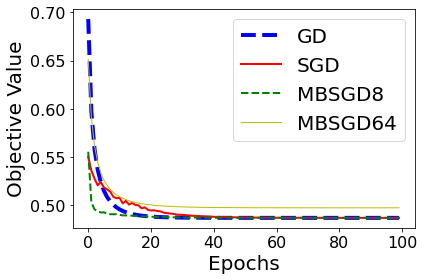

In [37]:
# plot the 4 curves:
fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '--g', LineWidth=2)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '-y', LineWidth=1)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MBSGD8','MBSGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd_mbsgd.pdf', format='pdf', dpi=1200)